In [ ]:
https://de.dariah.eu/tatom/working_with_text.html
http://brandonrose.org/clustering    

In [312]:
import json
import nltk
import numpy as np
import re #regular expression library
with open('lyrics_dict.json', 'r') as fp:
    data_json = json.load(fp)

In [313]:
# make this into two lists: tracks and lyrics

tracks = list(data_json.keys())
lyrics = list(data_json.values())

In [314]:
#lyrics

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html for parameters for TdifVectorizer

In [315]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [316]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [317]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in lyrics:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [318]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
#len(vocab_frame)

In [319]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.6,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True)

%time tfidf_matrix = tfidf_vectorizer.fit_transform(lyrics) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

Wall time: 135 ms
(1000, 62)


In [320]:
terms = tfidf_vectorizer.get_feature_names()

In [321]:
#print(tfidf_matrix)

In [322]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# Kmeans Clustering

In [323]:
from sklearn.cluster import KMeans

# might want to change this.
num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 439 ms


In [324]:
from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl')


['doc_cluster.pkl', 'doc_cluster.pkl_01.npy', 'doc_cluster.pkl_02.npy']

In [325]:
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [326]:
## not mine: generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []

for i in range(0,len(tracks)):
    ranks.append(i)

In [327]:
import pandas as pd

songs = { 'track': tracks, 'rank': ranks, 'lyrics': lyrics, 'cluster': clusters,}

frame = pd.DataFrame(songs, index = [clusters] , columns = ['rank', 'track', 'cluster'])

In [328]:
frame['cluster'].value_counts()

3    419
2    370
0    110
4     61
1     40
Name: cluster, dtype: int64

In [329]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()

cluster
0    451.536364
1    503.900000
2    505.148649
3    512.696897
4    458.196721
Name: rank, dtype: float64

In [330]:
# I dont know if I need this
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [331]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print()
    print()
''' print("Cluster %d tracks:" % i, end='')
    for track in frame.ix[i]['track'].values.tolist():
        print(' %s,' % track, end='')
    print()
    print()'''

Top terms per cluster:

Cluster 0 words: love, know, heart, ca, let, babi,

Cluster 1 words: die, fall, live, wo, life, man,

Cluster 2 words: know, just, like, got, say, make,

Cluster 3 words: oh, time, world, life, away, wo,

Cluster 4 words: come, home, feel, like, oh, way,



' print("Cluster %d tracks:" % i, end=\'\')\n    for track in frame.ix[i][\'track\'].values.tolist():\n        print(\' %s,\' % track, end=\'\')\n    print()\n    print()'

In [332]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'love, know, heart, ca, let, babi', 
                 1: 'die, fall, live, wo, life, man', 
                 2: 'know, just, like, got, say, make', 
                 3: 'oh, time, world, life, away, wo', 
                 4: 'come, home, feel, like, oh, way'}

In [333]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

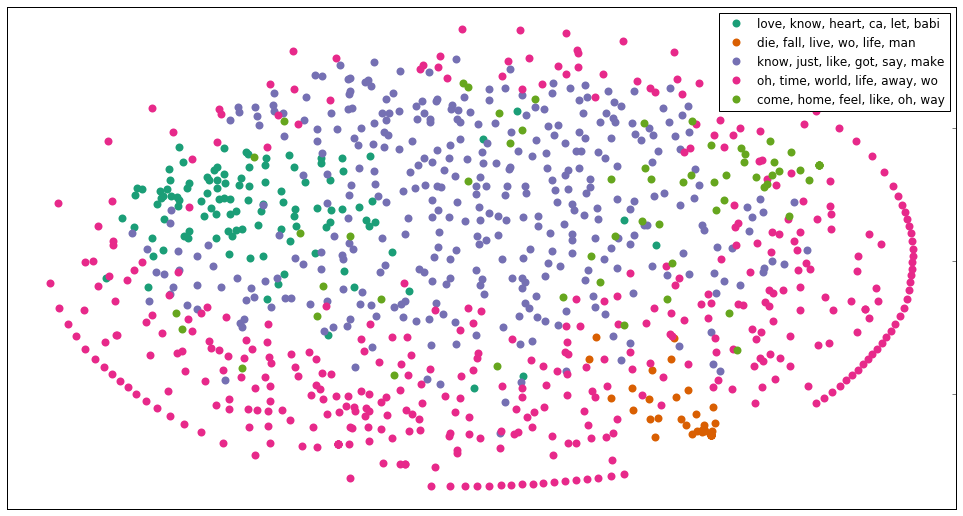

In [334]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=tracks)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
#    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)